In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.impute import SimpleImputer 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collaborative Filtering

In [3]:
tea_df = pd.read_csv('data/tea_data.csv')
tea_df['Tea ID'] = tea_df['Tea Name'] + tea_df['Brand']
tea_df['Tea ID'] = tea_df['Tea ID'].astype('category').cat.codes

user_item_matrix = tea_df.pivot_table(
    index='Account Id',
    columns='Tea ID',
    values='Total Rating')

In [4]:
def transform_collab_matrix(user_item_matrix):
    # min-max scaling
    min_array = user_item_matrix.min(axis=1).values.reshape(-1, 1)
    max_array = user_item_matrix.max(axis=1).values.reshape(-1, 1)
    user_item_matrix_scaled = (user_item_matrix - min_array) / (max_array - min_array)

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
    user_item_matrix_filled = imputer.fit_transform(user_item_matrix.T) 
    user_item_matrix_filled = pd.DataFrame(user_item_matrix_filled.T,
                                           index=user_item_matrix.index,
                                           columns=user_item_matrix.columns)
    # ii similarity 
    item_similarity = cosine_similarity(user_item_matrix_scaled.fillna(0).T)
    item_sim_df = pd.DataFrame(
        item_similarity,
        index=user_item_matrix_scaled.columns,
        columns=user_item_matrix_scaled.columns)
    
    return user_item_matrix_filled, item_sim_df

In [5]:
user_item_matrix_filled, item_sim_df = transform_collab_matrix(user_item_matrix)

In [6]:
# predict tea rating
def predict_rating_user_user(user_id, tea_name, similarity, user_item_ratings, k=5):
    sim_scores = similarity.loc[tea_name].drop(tea_name)
    item_ratings = user_item_ratings.drop(tea_name, axis=1).loc[user_id]
    
    mask = ~np.isnan(item_ratings)
    sim_scores = sim_scores[mask]
    item_ratings = item_ratings[mask]
    
    if sim_scores.sum() == 0: return item_ratings.mean()
    top_k_items = sim_scores.sort_values(ascending=False).head(k)
    top_k_ratings = item_ratings[top_k_items.index]
    
    return np.dot(top_k_items, top_k_ratings) / top_k_items.sum()

# Content-Based Filtering

In [7]:
embeds = pd.read_csv("data/content_embeddings.csv", header = None)
embeds['Tea ID'] = tea_df['Tea ID']
embeds = embeds.drop_duplicates(subset='Tea ID')
embeds = embeds.set_index('Tea ID')
embeds = embeds.sort_index()

In [8]:
# # Categorical One-Hot Encodings
# one_hot = tea_df[['Brand', 'Style', 'Region', 'Caffeine', 'Loose Type']]
# one_hot = pd.get_dummies(one_hot)

# one_hot['Tea ID'] = tea_df['Tea ID']
# one_hot = one_hot.drop_duplicates(subset='Tea ID')
# one_hot = one_hot.set_index('Tea ID')
# one_hot = one_hot.sort_index()

# embeds = one_hot

In [9]:
tea_matrix_content = embeds
tea_names_content = embeds.index

# cosine similarity 
tea_similarity_content = cosine_similarity(tea_matrix_content)
tea_similarity_content_df = pd.DataFrame(
    tea_similarity_content,
    index=embeds.index,
    columns=embeds.index)

In [10]:
def predict_rating_content(user_id, tea_name, similarity, user_item_ratings, k=5):       
    sim_scores = similarity.loc[tea_name]
    user_ratings = user_item_ratings.loc[user_id, :]
    
    mask = ~np.isnan(user_ratings)
    sim_scores = sim_scores[mask]
    user_ratings = user_ratings[mask]

    top_k_items = sim_scores.sort_values(ascending=False).head(k)
    top_k_ratings = user_ratings[top_k_items.index]
    return np.dot(top_k_items, top_k_ratings) / top_k_items.sum()

# Hybrid

Prepare Data for Training and Testing

In [11]:
test_size = int(len(user_item_matrix) * .3)

train_user_item_matrix = user_item_matrix[:-test_size]
test_user_item_matrix = user_item_matrix[-test_size:]

In [12]:
train_user_item_matrix_filled, train_item_sim_df = transform_collab_matrix(train_user_item_matrix)

In [13]:
# get ratings, tea, user data
test_ratings = []
for user in test_user_item_matrix.index:
    for tea in test_user_item_matrix.columns:
        rating = test_user_item_matrix.loc[user, tea]
        if not np.isnan(rating):
            test_ratings.append((user, tea, rating))

Generate Test Predictions

In [14]:
def combine_ratings_simple(collab_rating, content_rating, collab_w = .5):
    return collab_rating * collab_w + content_rating * (1-collab_w)

In [15]:
# finding rmse
actuals = []
preds = []
preds_coll = []
preds_cont = []
for user, tea, actual_rating in test_ratings:
    # get collaborative, content, and hybrid ratings
    collab_pred_rating = predict_rating_user_user(user, tea, train_item_sim_df, user_item_matrix)
    content_pred_rating = predict_rating_content(user, tea, tea_similarity_content_df, user_item_matrix)
    hybrid_pred_rating = combine_ratings_simple(collab_pred_rating, content_pred_rating, collab_w=.5)
    
    actuals.append(actual_rating)
    preds.append(hybrid_pred_rating)
    preds_coll.append(collab_pred_rating)
    preds_cont.append(content_pred_rating)

In [16]:
rmse_collab = sqrt(mean_squared_error(actuals, preds_coll))
rmse_content = sqrt(mean_squared_error(actuals, preds_cont))
rmse_hybrid = sqrt(mean_squared_error(actuals, preds))
print(f"RMSE on test collab: {rmse_collab:.4f}")
print(f"RMSE on test content: {rmse_content:.4f}")
print(f"RMSE on test hybrid: {rmse_hybrid:.4f}")

RMSE on test collab: 15.0662
RMSE on test content: 12.2473
RMSE on test hybrid: 13.0526


# Tea Recommendation

In [17]:
tea_name_lookup = tea_df[['Tea Name', 'Tea ID']].drop_duplicates()
tea_name_lookup = tea_name_lookup.set_index('Tea ID')

In [18]:
# recommending top n teas
def recommend_top_teas(user_id, similarity_coll, similarity_cont, user_item_ratings, n=5):
    user_ratings = user_item_ratings.loc[user_id]
    unrated_teas = user_ratings[user_ratings == 0].index
    predicted_scores = {}
    for tea in unrated_teas:
        collab_pred_rating = predict_rating_user_user(user, tea, similarity_coll, user_item_ratings)
        content_pred_rating = predict_rating_content(user, tea, similarity_cont, user_item_ratings)
        pred = combine_ratings_simple(collab_pred_rating, content_pred_rating)
        predicted_scores[tea] = pred
        
    sorted_recs = sorted(predicted_scores.items(), key=lambda x: x[1], reverse=True)
    teas = sorted_recs[:n]
    for t in range(len(teas)):
        teas[t] = (tea_name_lookup.loc[teas[t][0]].item(), round(teas[t][1], 3))
    return teas

In [19]:
uid_test = 1
teas = recommend_top_teas(uid_test, item_sim_df, tea_similarity_content_df, user_item_matrix, n=1)
print(f'For user {uid_test} the recommended teas are:')
print(teas)

For user 1 the recommended teas are:
[('Breakfast Special - Christmas Blend', 74.563)]


<br></br>

<br></br>

<br></br>

<br></br>

# Visualization

Table Numbers:

- Collab user-user (17.9071)
- Collab item-item (15.0662)
- Content embed (12.2473)
- Content no embed (14.0180)
- Hybrid (13.0526)

- sim_cont - sim_collab
- distribution of similarity per tea (how many similar teas are there?) -> specific example by tea and mean
- overall similarity distribution
- prediction scatterplot (with line of hybrid?)

In [27]:
def histplot(data, title='', xlabel=''):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    ax = sns.histplot(
        data=data,
        color="#3498db",
        fill=True,
        alpha=0.7,
        bins=30,
        edgecolor="white",
        linewidth=0.5
    )
    
    # Set title and labels with custom fonts and sizes
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    
    # Add a grid to the y-axis only
    ax.grid(axis='y', alpha=0.3)
    
    # Customize the spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()

In [73]:
def scatterplot(data, labels, title):
    df = pd.DataFrame({'x': data[0], 'y': data[1]}) 

    plt.figure(figsize=(10, 6))
    plt.xlim(30, 100)
    plt.ylim(-10, 110)
    
    scatter = sns.scatterplot(
        data=df,
        x='x',
        y='y',
        color='#3498db',  
        alpha=0.7,
        s=50,  
        edgecolor='white',
        linewidth=0.5
    )
    line_x = np.array([30, 100])
    plt.plot(line_x, line_x, color='red', linewidth=2)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(labels[0], fontsize=12)
    plt.ylabel(labels[1], fontsize=12)
    
    sns.despine()
    plt.tight_layout()


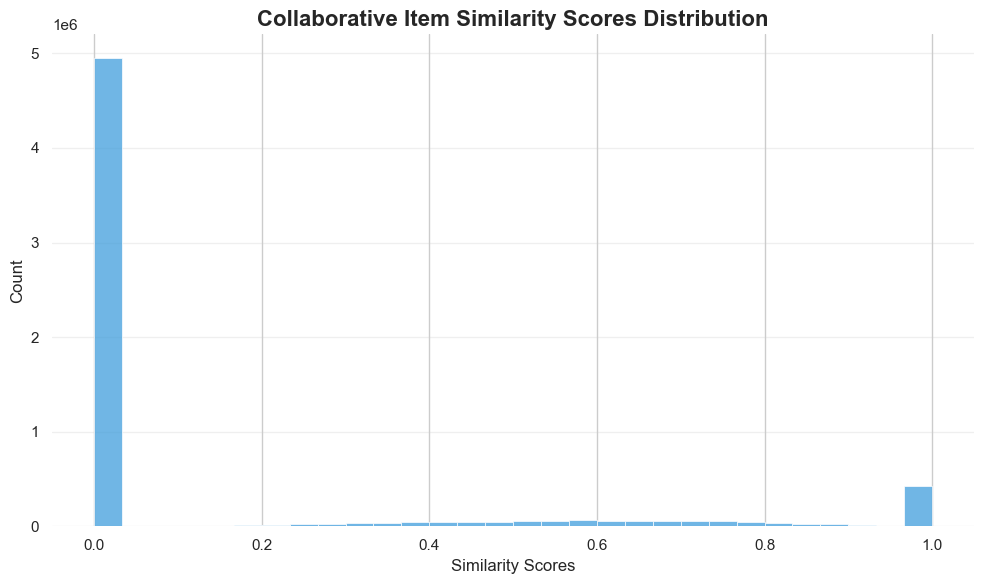

In [34]:
plt_sim = np.tril(item_sim_df + 10, k = -1).flatten()
plt_sim = plt_sim[plt_sim != 0]
plt_sim -= 10

histplot(plt_sim, title="Collaborative Item Similarity Scores Distribution", xlabel="Similarity Scores")

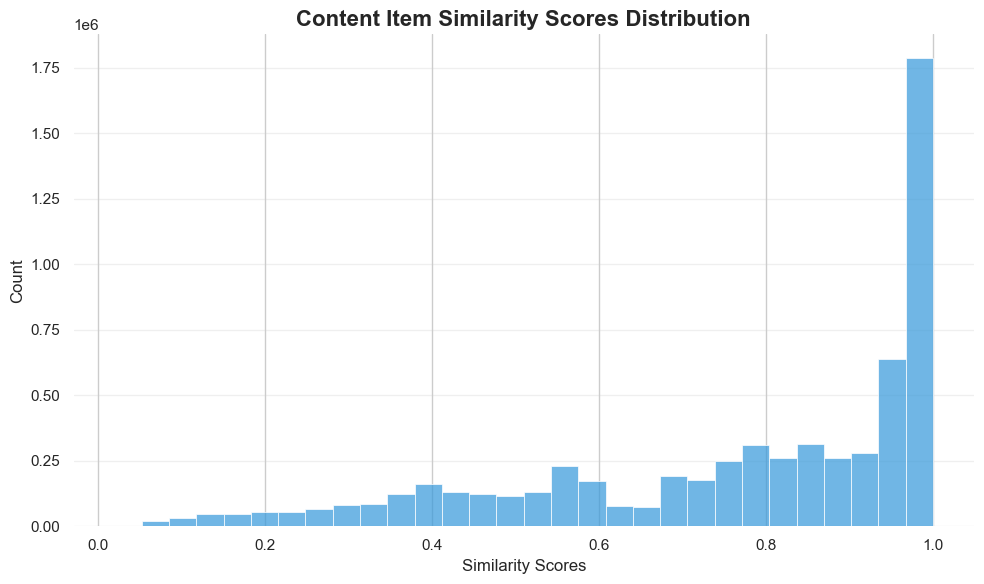

In [35]:
plt_sim = np.tril(tea_similarity_content_df + 10, k = -1).flatten()
plt_sim = plt_sim[plt_sim != 0]
plt_sim -= 10

histplot(plt_sim, title="Content Item Similarity Scores Distribution", xlabel="Similarity Scores")

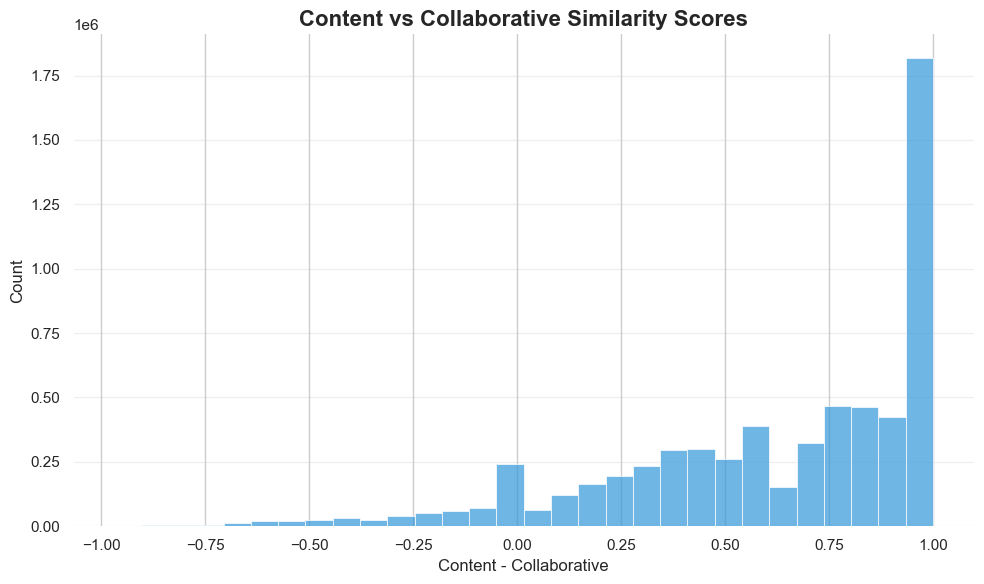

In [29]:
histplot(dif, title="Content vs Collaborative Similarity Scores", xlabel="Content - Collaborative")

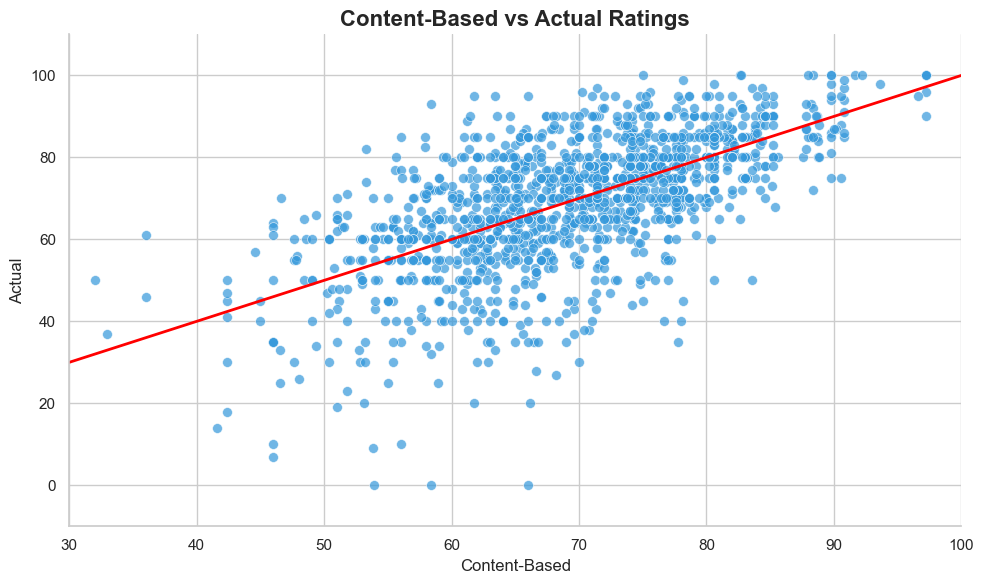

In [72]:
scatterplot([preds_cont, actuals], ['Content-Based', 'Actual'], 'Content-Based vs Actual Ratings')

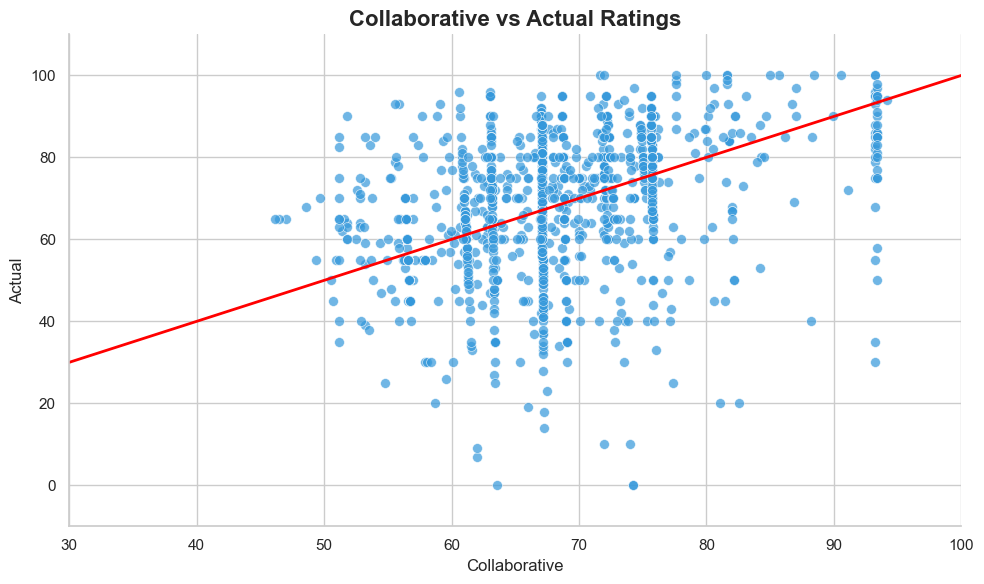

In [66]:
scatterplot([preds_coll, actuals], ['Collaborative', 'Actual'], 'Collaborative vs Actual Ratings')

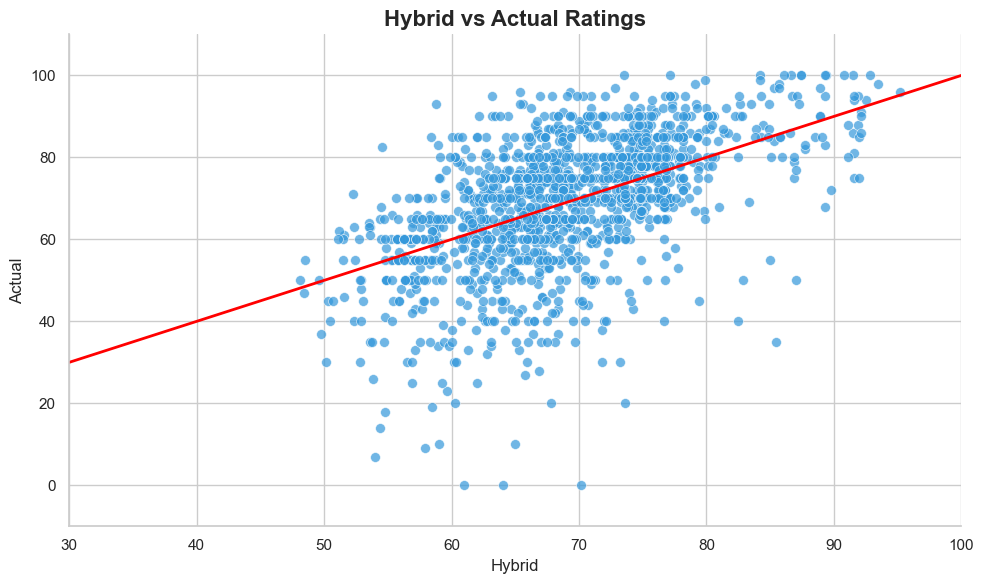

In [67]:
scatterplot([preds, actuals], ['Hybrid', 'Actual'], 'Hybrid vs Actual Ratings')

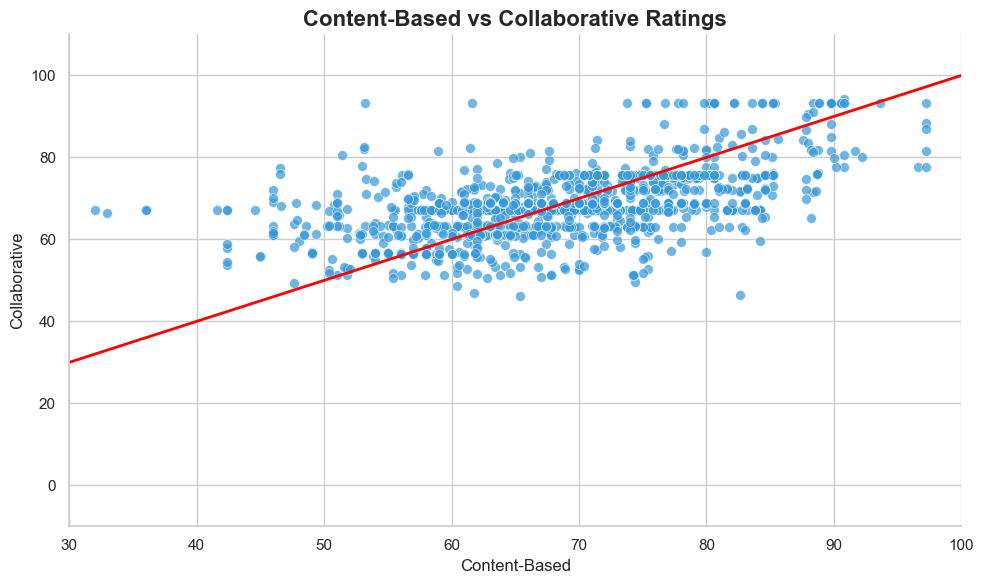

In [68]:
scatterplot([preds_cont, preds_coll], ['Content-Based', 'Collaborative'], 'Content-Based vs Collaborative Ratings')